In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()
import nest_asyncio
nest_asyncio.apply()

/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


In [2]:
import random
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('../model_data/quality_nj2.csv')
encoder1, encoder2, encoder3, encoder4 = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['RATER_CODE'] = encoder4.fit_transform(df['RATER'])
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
#from scipy.spatial.distance import cdist
#coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
#distances = cdist(coords.T,coords.T, metric='euclidean')
year = pd.to_datetime(df['DATE']).dt.year
num_days_in_year = pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year * 366 + (~pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year) * 365
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear
df['TIME_OF_YEAR'] = df['DAY_OF_YEAR']/num_days_in_year
df['ENTRY_CUMCOUNT'] = df.groupby('ENTRY_NAME').cumcount() + 1
df.head()

/tmp/ipykernel_14811/3976686709.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year = pd.to_datetime(df['DATE']).dt.year
/tmp/ipykernel_14811/3976686709.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear


PLT_ID         TRAIT     DATE  QUALITY  ENTRY_CODE  ENTRY_NAME  \
0     241  Turf Quality  4/18/18        4          37  NAI-14-132   
1     241  Turf Quality  5/10/18        4          37  NAI-14-132   
2     241  Turf Quality   6/7/18        5          37  NAI-14-132   
3     241  Turf Quality  7/17/18        5          37  NAI-14-132   
4     241  Turf Quality  8/15/18        6          37  NAI-14-132   

                  COMP RATER  ROW  COL  ...  RATING_EVENT_CODE  MONTH_CODE  \
0  Columbia River Seed   RMD   17    1  ...                  7           1   
1  Columbia River Seed   RON   17    1  ...                 12           6   
2  Columbia River Seed   RON   17    1  ...                 13           4   
3  Columbia River Seed   RON   17    1  ...                 14           3   
4  Columbia River Seed   RMD   17    1  ...                  8           2   

  YEAR_CODE      TEST_LOC  ENTRY_NAME_CODE  PLT_ID_CODE  RATER_CODE  \
0         1  Adelphia, NJ               62          238           3   
1         1  Adelphia, NJ               62          238           4   
2         1  Adelphia, NJ               62          238           4   
3         1  Adelphia, NJ               62          238           4   
4         1  Adelphia, NJ               62          238           3   

  DAY_OF_YEAR  TIME_OF_YEAR  ENTRY_CUMCOUNT  
0         108      0.295890               1  
1         130      0.356164               2  
2         158      0.432877               3  
3         198      0.542466               4  
4         227      0.621918               5  

[5 rows x 24 columns]

In [3]:
df.groupby('RATER_CODE')['PLT_ID'].count()

RATER_CODE
0     267
1     801
2     801
3    1335
4    3204
5    1602
6    1602
Name: PLT_ID, dtype: int64

In [4]:
df['TIME_OF_YEAR']+df['YEAR']

0       2018.295890
1       2018.356164
2       2018.432877
3       2018.542466
4       2018.621918
           ...     
9607    2021.531507
9608    2021.610959
9609    2021.712329
9610    2021.783562
9611    2021.882192
Length: 9612, dtype: float64

In [5]:
padding = 5 # adjustable
num_rows = 18
num_cols = 15
pred_N = 100
num_basis_functions = 6
stan_data_time = {"N": len(df["QUALITY"]),                 # Number of responses
             "num_raters":len(df['RATER'].unique()),         # Total number of rating events
             "num_entries":len(df['ENTRY_NAME'].unique()),           # Total number of entries (turfgrass types)
             "num_plots":len(df['PLT_ID'].unique()),               # Total number of plots 
             "num_categories": 9,                                       # Total number of rating categories
             "num_events_by_rater": df.groupby('RATER_CODE')['PLT_ID'].count(),
             "smoothing_factor": 8,
             "rater_id": df["RATER_CODE"].values+1,       # rating id for y[n], defined by rater + date
             "entry_id": df["ENTRY_NAME_CODE"].values+1,         # entry of y[n]
             "plot_id": df["PLT_ID_CODE"].values+1,             # plot id of y[n]
             "y": df["QUALITY"].values,                    # the rating value of y[n]
              # new values for fourier data
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int),
             # values used for time GP
             "time" : df['TIME_OF_YEAR']+df['YEAR'],
             "c_f" : 1.5,
             "M_f":num_basis_functions, # number of Hilbert Basis functions
             "num_ratings_per_entry": np.max(df.groupby('ENTRY_NAME').count()['PLT_ID']),
             "entry_cumcount": df["ENTRY_CUMCOUNT"],

             "pred_N": pred_N,
             "pred_time": np.linspace(0,1,pred_N+1)[1:]
            #"pred_rating_event_id": None,
            #"pred_entry_id": None,
            #"pred_plot_id":None,
            #"pred_day":None
              }

In [6]:
model = compile_model(stan_file="fourier_model_time_effect_distinct_entries_v8_sharedparams.stan", force_compile=True)

19:05:56 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
19:05:56 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams
19:06:37 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams


In [7]:
fit = model.sample(stan_data_time)

19:06:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status
chain 1 |████▍                                                                                            | 00:00 Status


chain 4 |████▍                                                                                            | 00:00 Status

chain 3 |████▍                                                                                            | 00:00 Status

chain 3 |█████▊                                                          | 16:04 Iteration:


23:54:50 - cmdstanpy - INFO - CmdStan done processing.
23:54:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distinct_entries_v8_sharedparams.stan', line 12, column 4 to column 40) (in 'fourier_model_time_effect_distinct_entries_v8_sharedparams.stan', line 166, column 3 to column 114)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distinct_entries_v8_sharedparams.stan', line 12, column 4 to column 40) (in 'fourier_model_time_effect_distinct_entries_v8_sharedparams.stan', line 166, column 3 to column 114)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect_distin

23:54:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 157 iterations at max treedepth (15.7%)
	Chain 2 had 1000 iterations at max treedepth (100.0%)
	Chain 3 had 36 iterations at max treedepth (3.6%)
	Chain 4 had 550 iterations at max treedepth (55.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


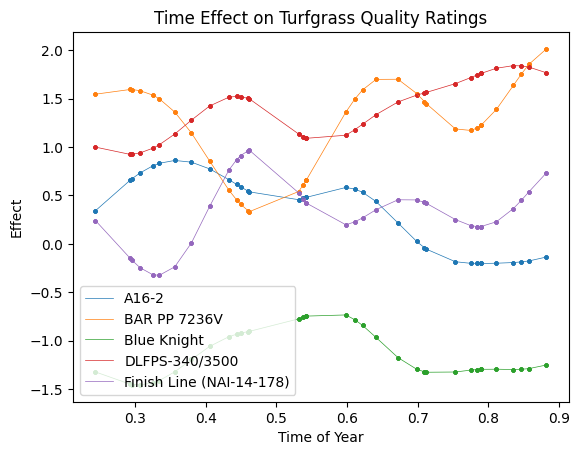

In [8]:
for i in [10,20,30,40,50]:
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[1500:,i].mean(axis=0)[ind] for ind in sorted_indices]
    plt.scatter(x_sorted, y_sorted,s=5)
    plt.plot(x_sorted,y_sorted,linewidth=0.5, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Time Effect on Turfgrass Quality Ratings')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

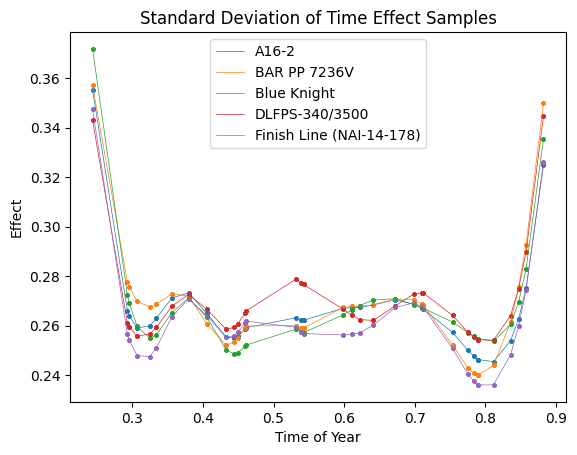

In [9]:
for i in [10,20,30,40,50]:
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[1500:,i].std(axis=0)[ind] for ind in sorted_indices]
    plt.scatter(x_sorted, y_sorted,s=5)
    plt.plot(x_sorted,y_sorted,linewidth=0.5, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Standard Deviation of Time Effect Samples')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

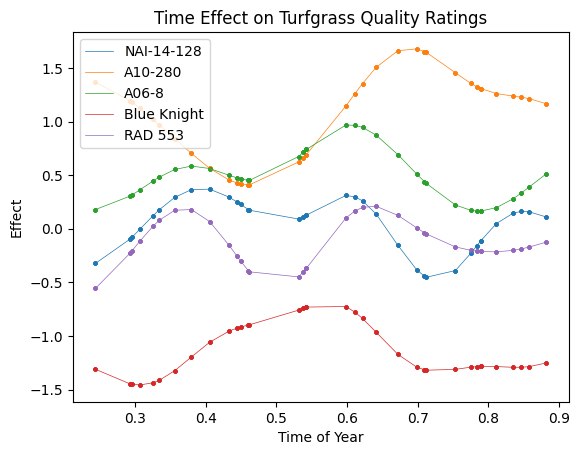

In [11]:
rand_entries = [i for i in range(stan_data_time["num_entries"])]
random.shuffle(rand_entries)
for i in rand_entries[:5]:
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]
    plt.scatter(x_sorted,y_sorted,s=5)
    plt.plot(x_sorted,y_sorted,linewidth=0.5, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Time Effect on Turfgrass Quality Ratings')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

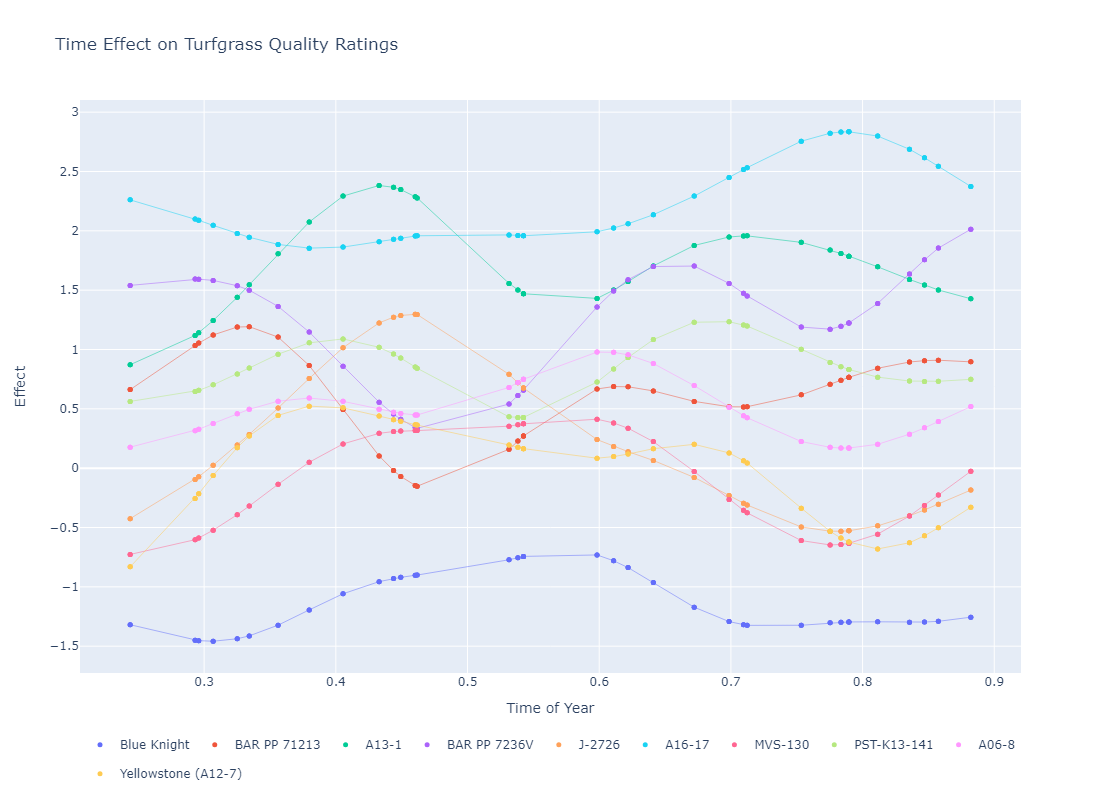

In [42]:
import plotly.graph_objects as go
import plotly.io as pio
import random

rand_entries = [i for i in range(stan_data_time["num_entries"])]
random.shuffle(rand_entries)
fig = go.Figure()

colors = pio.templates["plotly"].layout.colorway

for idx, i in enumerate(rand_entries[:len(colors)]):
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]
    
    entry_name = list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0]
    
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='markers', marker=dict(size=5, color=colors[idx]),
                             name=entry_name, legendgroup=entry_name))
    
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='lines', line=dict(width=0.5, color=colors[idx]),
                             name=entry_name, showlegend=False, legendgroup=entry_name))

fig.update_layout(title='Time Effect on Turfgrass Quality Ratings',
                  xaxis_title='Time of Year',
                  yaxis_title='Effect',
                  width=1200,  # Set the width of the figure in pixels
                  height=800,  # Set the height of the figure in pixels
                  legend=dict(orientation="h", tracegroupgap=10))

fig.show()

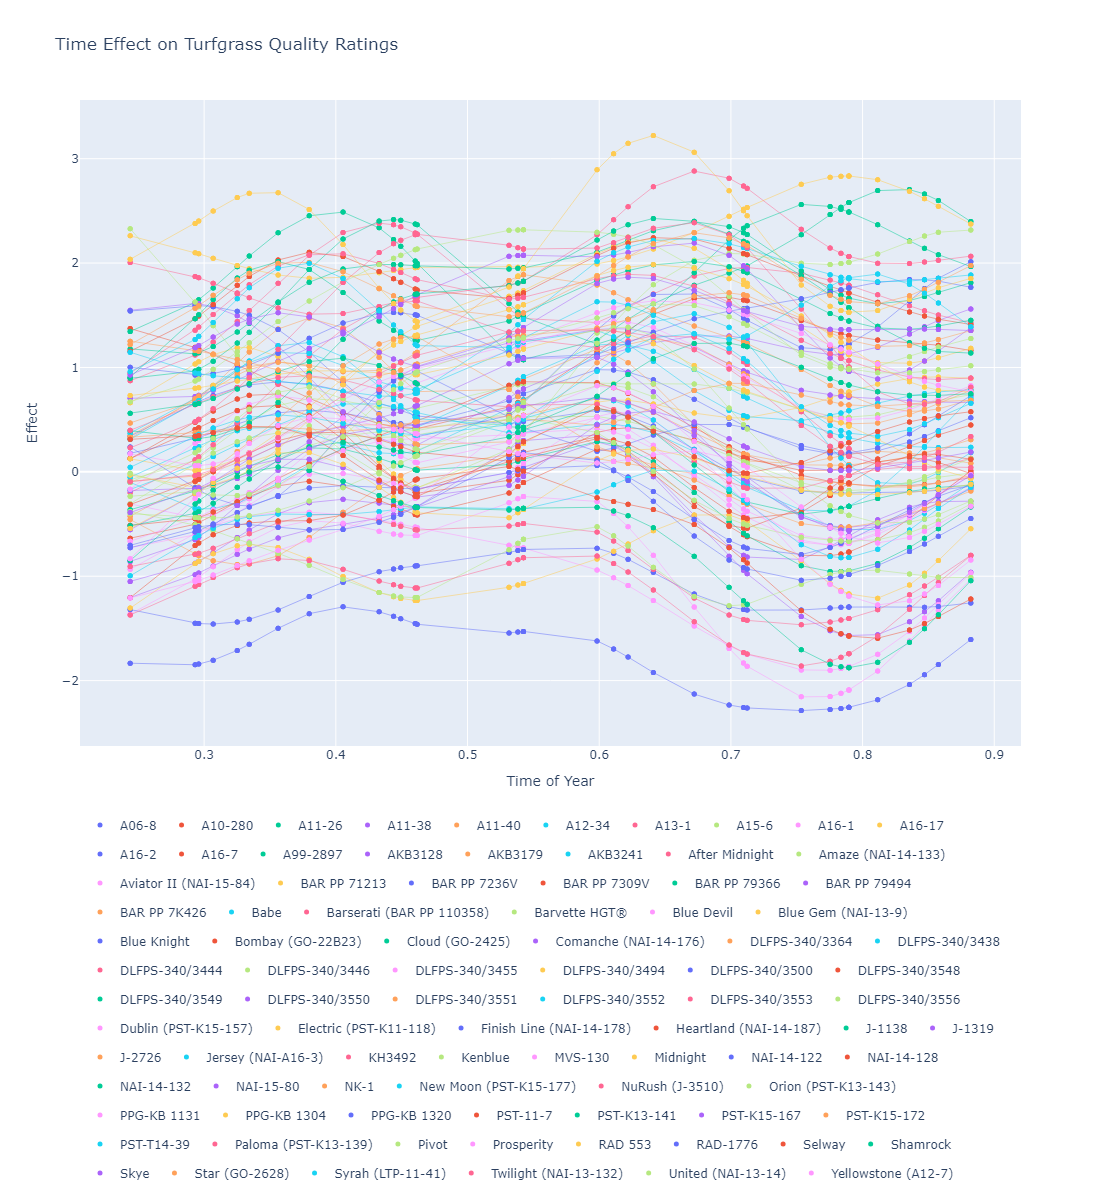

In [40]:
fig = go.Figure()
colors = pio.templates["plotly"].layout.colorway
for idx, i in enumerate([i for i in range(stan_data_time["num_entries"])]):
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]
    
    entry_name = list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0]
    
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='markers', marker=dict(size=5, color=colors[idx%len(colors)]),
                             name=entry_name, legendgroup=entry_name))
    
    fig.add_trace(go.Scatter(x=x_sorted, y=y_sorted, mode='lines', line=dict(width=0.5, color=colors[idx%len(colors)]),
                             name=entry_name, showlegend=False, legendgroup=entry_name))

fig.update_layout(title='Time Effect on Turfgrass Quality Ratings',
                  xaxis_title='Time of Year',
                  yaxis_title='Effect',
                  width=1200,  # Set the width of the figure in pixels
                  height=1200,  # Set the height of the figure in pixels
                  legend=dict(orientation="h", tracegroupgap=10))

fig.show()

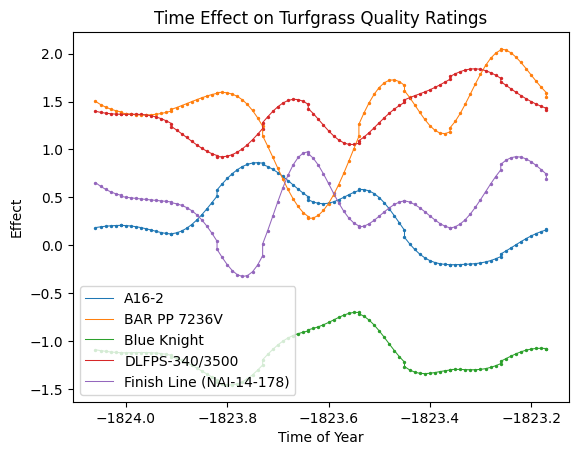

In [10]:
for i in [10,20,30,40,50]:
    x = list(fit.pred_xn.mean(axis=0))
    y = fit.pred_time_effect[:,i].mean(axis=0)
    plt.scatter(x,y,s=2)
    plt.plot(x,y,linewidth=0.75, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Time Effect on Turfgrass Quality Ratings')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

<Axes: >

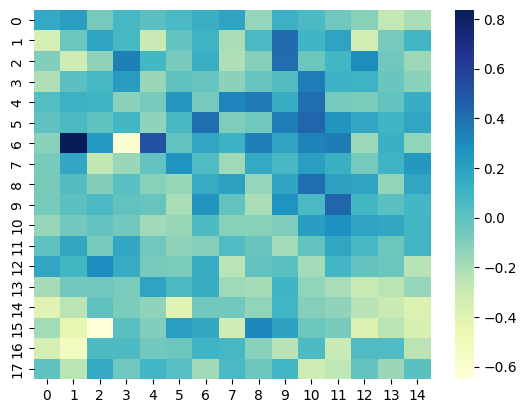

In [12]:
PLT_ROW = df.groupby('PLT_ID')[['ROW', 'COL']].max()['ROW']
PLT_COL = df.groupby('PLT_ID')[['ROW', 'COL']].max()['COL']
mean_matrix_time = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_time[PLT_ROW, PLT_COL] = fit.plot_effect.mean(axis=0)
sns.heatmap(mean_matrix_time[1:,1:], cmap="YlGnBu")

Cross Entropy Loss: 1.0473954841537971
Cross Entropy Loss: 1.6243479541995733
Cross Entropy Loss: 1.1277395711535467
Cross Entropy Loss: 1.6001573696057105
Cross Entropy Loss: 1.5355293033391457
Cross Entropy Loss: 1.4694299504479575


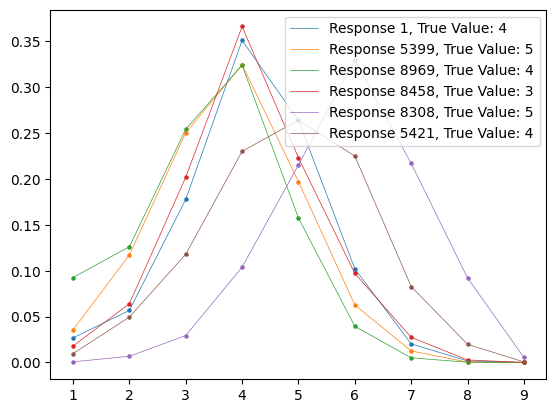

In [13]:
from scipy.special import softmax

def rsm_probability(y, theta, beta, tau):
    unsummed = np.concatenate(([0], theta - beta - tau))
    probs = softmax(np.cumsum(unsummed))
    return probs[y]
    
def cross_entropy_loss(y_true, y_pred):
    #print(y_pred)
    epsilon = 1e-15  # Small constant to avoid log(0) errors
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid extreme values
    return -np.log(y_pred[y_true])

tau = list(fit.tau_rsm.mean(axis=0))
#beta = list(fit.beta_rsm.mean(axis=0))
for n in [1]+[random.randint(0,9612) for i in range(5)]:
    #theta = fit.plot_effect.mean(axis=0)[df.loc[n]["PLT_ID_CODE"]+1] + fit.time_effect.mean(axis=0)[df.loc[n]["ENTRY_NAME_CODE"]+1][df.loc[n]["ENTRY_CUMCOUNT"]]
    thetaVec = fit.plot_effect[:,df.loc[n]["PLT_ID_CODE"]] + fit.time_effect[:,df.loc[n]["ENTRY_NAME_CODE"],df.loc[n]["ENTRY_CUMCOUNT"]-1]
    #sns.kdeplot(thetaVec)
    #beta_n = beta[df.loc[n]["RATER_CODE"]]
    tau_n = tau[df.loc[n]["RATER_CODE"]]
    probabs = np.array([[rsm_probability(i,thetaVec[j],0,tau_n) for i in range(10)] for j in range(4000)]).mean(axis=0)
    true_val = df["QUALITY"][n]
    print("Cross Entropy Loss: ",end='')
    print(cross_entropy_loss(true_val, [0]+probabs))
    plt.scatter([i for i in range(1,10)],probabs[1:],s=5)
    plt.plot([i for i in range(1,10)],probabs[1:],label=f"Response {n}, True Value: {true_val}",linewidth=0.5)
    #print(f"Response {n} True value: "+str(df["QUALITY"][n]))
plt.legend()
plt.show()

In [14]:
loss = []
tau = fit.tau_rsm.mean(axis=0)
for n in range(9612):
    #theta = fit.plot_effect.mean(axis=0)[df.loc[n]["PLT_ID_CODE"]+1] + fit.time_effect.mean(axis=0)[df.loc[n]["ENTRY_NAME_CODE"]+1][df.loc[n]["ENTRY_CUMCOUNT"]]
    thetaVec = fit.plot_effect[:,df.loc[n]["PLT_ID_CODE"]] + fit.time_effect[:,df.loc[n]["ENTRY_NAME_CODE"],df.loc[n]["ENTRY_CUMCOUNT"]-1]
    #sns.kdeplot(thetaVec)
    tau_n = tau[df.loc[n]["RATER_CODE"]]
    true_val = df["QUALITY"][n]
    probabs_true_val = np.array([rsm_probability(true_val,theta,0,tau_n) for theta in thetaVec]).mean()
    loss.append(-np.log(probabs_true_val))
    if n%961 == 0:
        print(n,end='')
        print(" : mean loss : "+str(np.array(loss).mean()))
print(np.array(loss).mean())

0 : mean loss : 1.5116481083994833
961 : mean loss : 1.541573909587164
1922 : mean loss : 1.5061979970893702
2883 : mean loss : 1.5042423337146569
3844 : mean loss : 1.491833560507361
4805 : mean loss : 1.4878290420760771
5766 : mean loss : 1.4907453532980006
6727 : mean loss : 1.4928360699015952
7688 : mean loss : 1.4964235277499611
8649 : mean loss : 1.494248121653553
9610 : mean loss : 1.4980776862887035
1.498066872133642


In [15]:
fit.time_effect[:,1].mean(axis=0).shape
fit.time_effect[:,1].shape

(4000, 108)

In [16]:
fit.lengthscale_f.mean(axis=0)

0.47480165125

In [17]:
fit.sigma_f.mean(axis=0)

0.14261557149999998

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


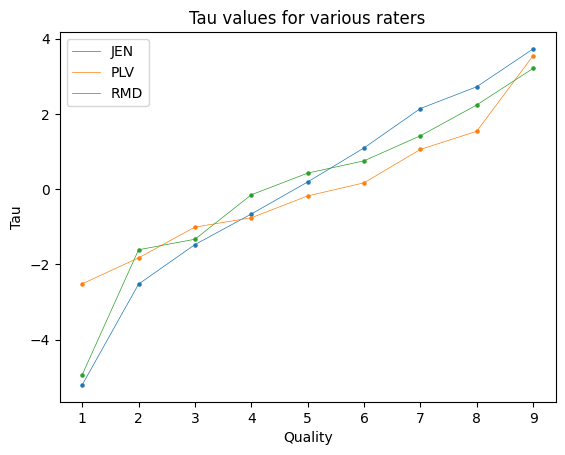

In [18]:
# make a rater dictionary
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

fit.tau_rsm.mean(axis=0)
for i in [1,2,3]:
    #tau_vals = list(fit.tau_rsm.mean(axis=0)[i])
    plt.scatter([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i],s=5)
    plt.plot([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i], label=rater_dict[i],linewidth=0.5)
plt.title("Tau values for various raters")
plt.xlabel("Quality")
plt.ylabel("Tau")
plt.legend()
plt.show()

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


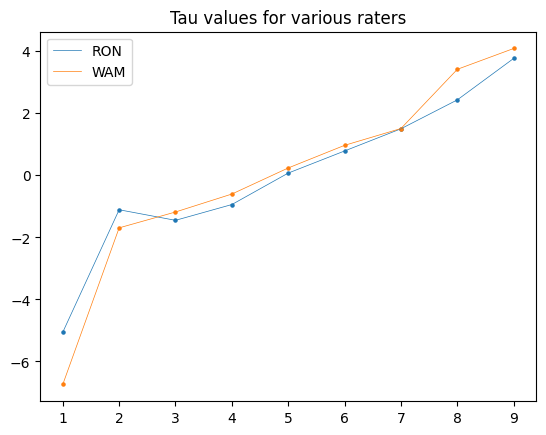

In [19]:
# make a rater dictionary
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

fit.tau_rsm.mean(axis=0)
for i in [4,6]:
    #tau_vals = list(fit.tau_rsm.mean(axis=0)[i])
    plt.scatter([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i],s=5)
    plt.plot([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i], label=rater_dict[i],linewidth=0.5)
plt.title("Tau values for various raters")
plt.legend()
plt.show()

In [20]:
import math
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


In [21]:
fit.intercept_f.mean(axis=0)

array([ 0.48848949,  1.09237708,  1.88081742, -0.69299144,  0.58654478,
        0.39653437,  1.57036372,  0.56777052, -0.97418907,  2.22285588,
        0.2812803 ,  0.09279709,  1.79548604,  1.17744872,  0.28269336,
        0.44873662,  0.66917624,  0.15445094, -1.01808951,  0.62324067,
        1.34169407,  0.24158496,  1.75249108,  0.651376  ,  0.67854533,
        0.11993197,  2.03608122,  1.52156741,  0.60219944,  1.09271332,
       -1.12406214,  1.69284596,  1.49911223, -0.44590723, -0.15935629,
        0.79208794, -0.79652265,  0.13701337,  0.04627917, -0.88328289,
        1.37556927,  0.00802384, -0.19770495,  1.42697577,  0.99803449,
        1.51305082,  1.40087623,  1.46986094, -0.19764079,  0.71267424,
        0.41988974, -0.21343099,  1.35344178,  0.11398967,  0.10191672,
        0.49474632,  0.37271933, -0.82704916, -0.11771444,  1.02844747,
       -0.32313099, -0.01082568, -0.03760528, -0.02607386,  0.5467899 ,
       -0.44124888,  1.35745592, -0.17930469,  0.87980247,  2.11

Text(0.5, 1.0, 'Mean Intercept for Each Entry')

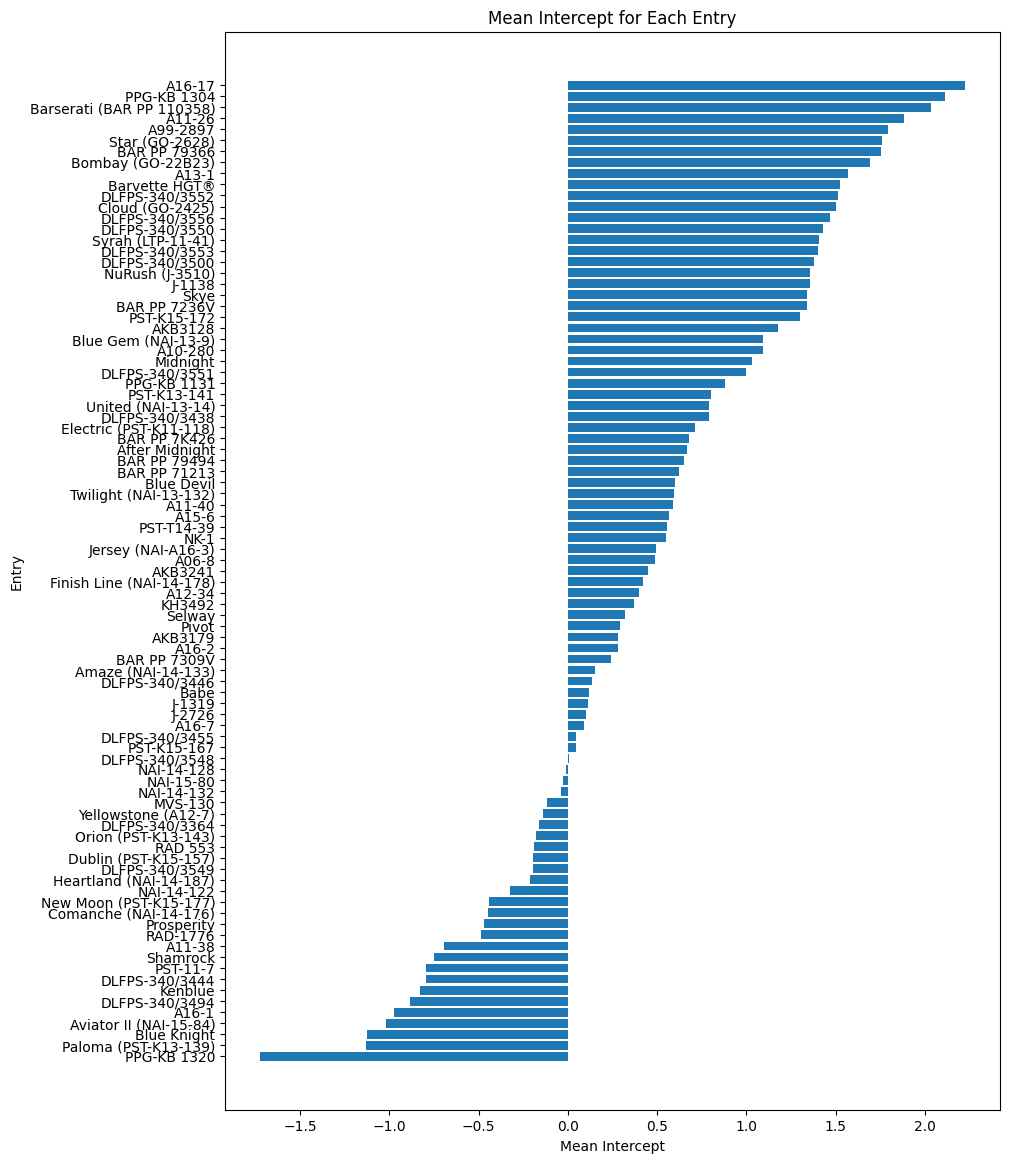

In [22]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.intercept_f.mean(axis=0))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]

entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)

bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Mean Intercept')
ax.set_title('Mean Intercept for Each Entry')

In [23]:
fit.time_effect.mean(axis=0).mean(axis=1)

array([ 4.84020935e-01,  1.06959551e+00,  1.99298441e+00, -6.89957783e-01,
        6.48358294e-01,  4.20370589e-01,  1.72020434e+00,  6.05258336e-01,
       -1.03231272e+00,  2.23811021e+00,  3.29154091e-01,  1.67528481e-01,
        1.82592852e+00,  1.07389035e+00,  2.84779796e-01,  4.88231743e-01,
        8.17213155e-01,  1.90847686e-01, -1.05496762e+00,  6.18161350e-01,
        1.22738386e+00,  2.34260541e-01,  1.88568353e+00,  7.38176784e-01,
        6.93261187e-01,  1.19049669e-01,  2.01835387e+00,  1.28988412e+00,
        6.30603180e-01,  1.17128254e+00, -1.13620271e+00,  1.80640901e+00,
        1.59623672e+00, -4.01081741e-01, -1.97278154e-01,  8.48709601e-01,
       -8.62651895e-01,  1.96721579e-01,  4.10083261e-02, -9.08656095e-01,
        1.39954342e+00, -6.81443300e-02, -2.31060494e-01,  1.43780399e+00,
        1.09115710e+00,  1.47414431e+00,  1.53237471e+00,  1.57360638e+00,
       -1.86545584e-01,  7.99555223e-01,  3.21404328e-01, -1.83426904e-01,
        1.47727645e+00,  

Text(0.5, 1.0, 'Mean Time Effect Recorded for Each Entry')

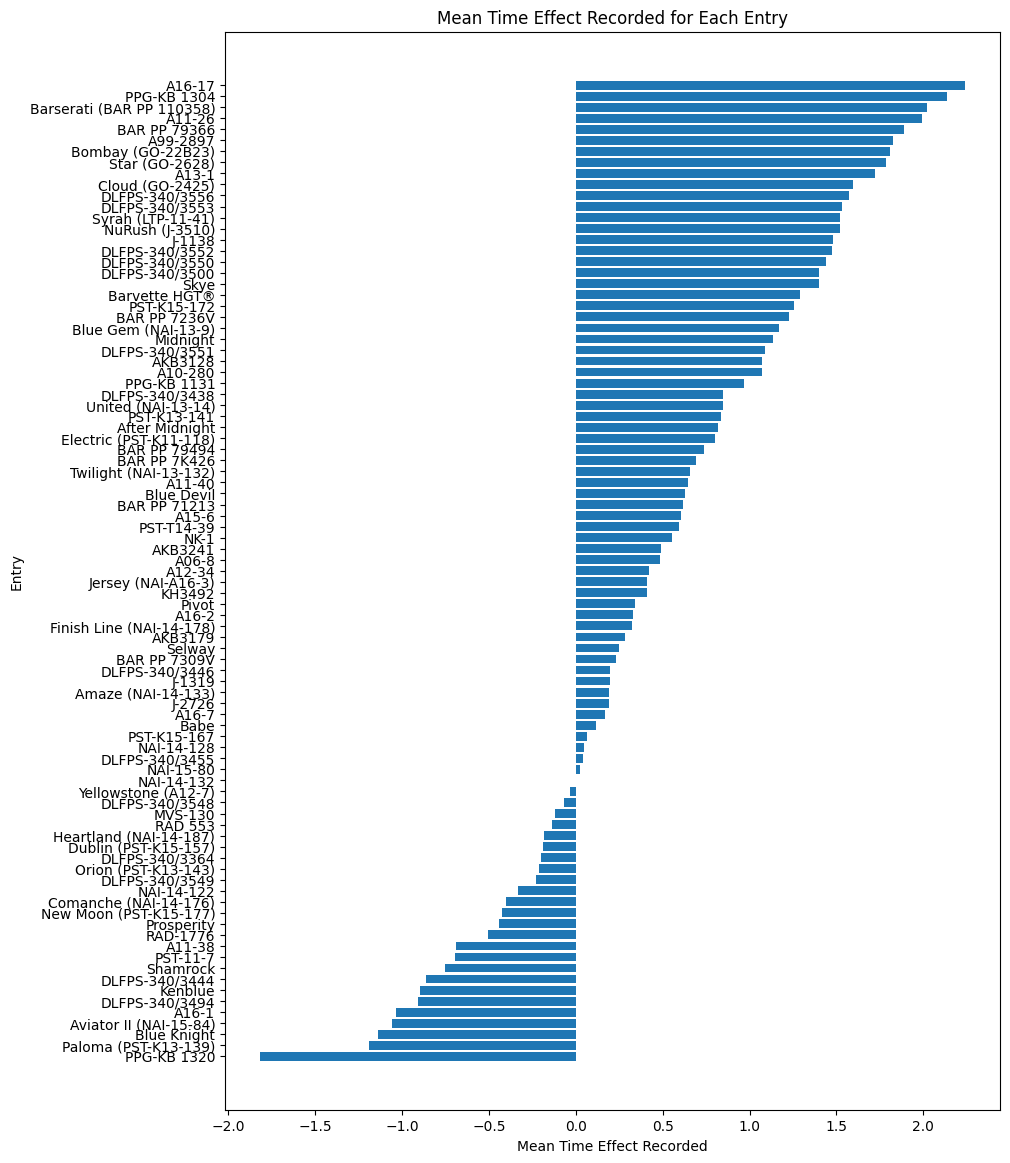

In [24]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.time_effect.mean(axis=0).mean(axis=1))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]
entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)
bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Mean Time Effect Recorded')
ax.set_title('Mean Time Effect Recorded for Each Entry')

In [25]:
fit.lengthscale_plot.mean(axis=0)

0.334901222775

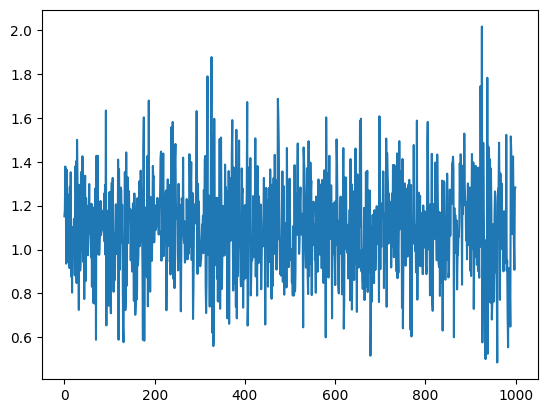

In [26]:
plt.plot(fit.intercept_f[2000:3000,1])

In [26]:
import pickle
with open("jan-14-2024-modelv8-sharedparams.pkl", "wb") as f:
    pickle.dump({'model' : model, 'fit' : fit, 'data' : stan_data_time}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

<Axes: ylabel='Density'>

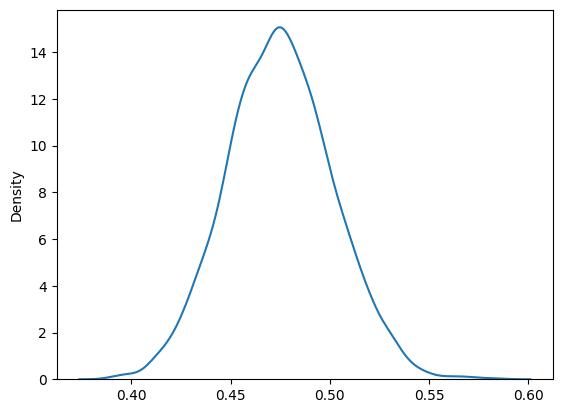

In [13]:
sns.kdeplot(fit.lengthscale_f)

<Axes: ylabel='Density'>

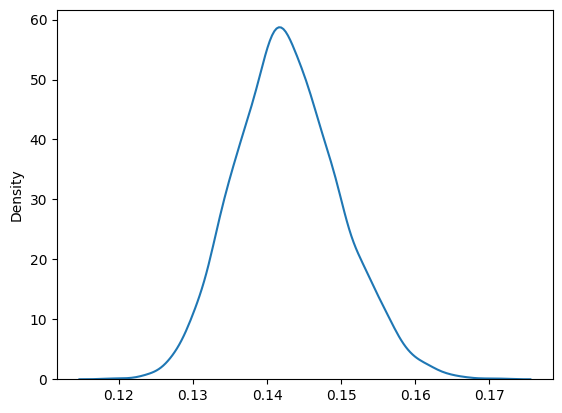

In [14]:
sns.kdeplot(fit.sigma_f)

<Axes: ylabel='Density'>

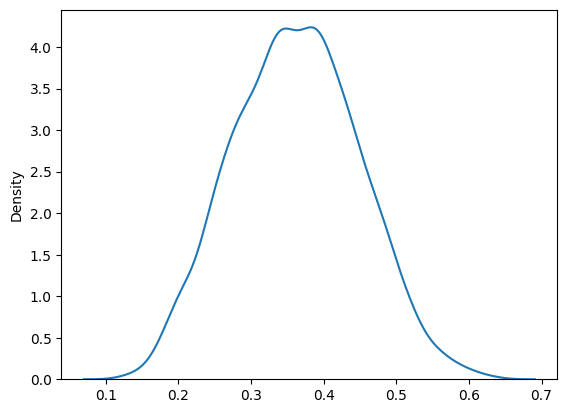

In [15]:
sns.kdeplot(fit.lengthscale_plot)

In [24]:
import pickle
with open("jan-14-2024-modelv8-sharedparams.pkl", "rb") as f:
    fit = pickle.load(f)['fit']

FileNotFoundError: [Errno 2] No such file or directory: 'jan-14-2024-modelv8-sharedparams.pkl'

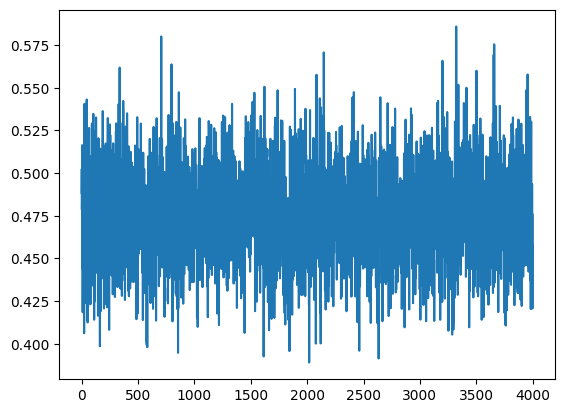

In [17]:
plt.plot(fit.lengthscale_f)

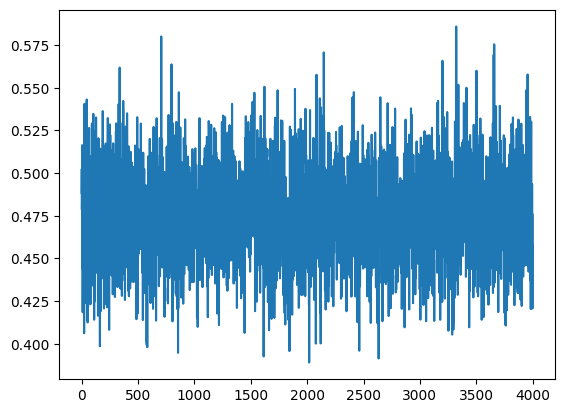

In [18]:
plt.plot(fit.lengthscale_f[:4000])

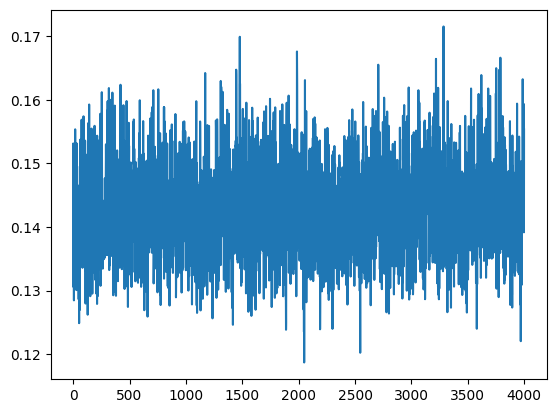

In [19]:
plt.plot(fit.sigma_f)

In [20]:
import arviz as az
az_data = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"y": stan_data_time['y']},
    log_likelihood="log_lik",
)
az_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

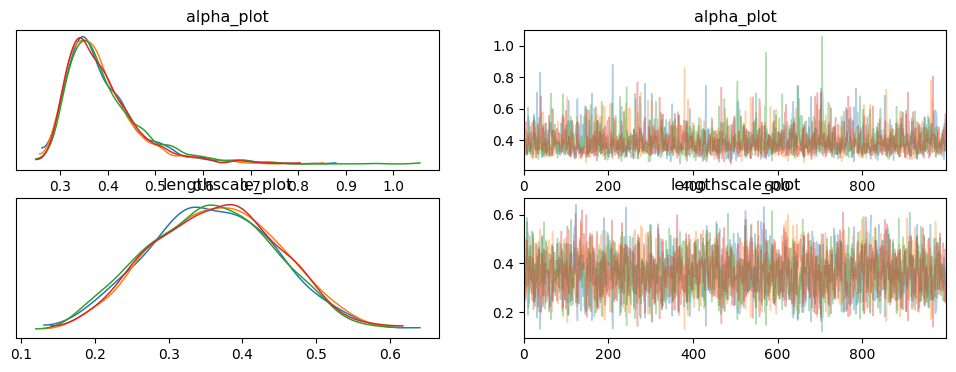

In [27]:
az.plot_trace(az_data, compact=False, var_names=['alpha_plot','lengthscale_plot']);

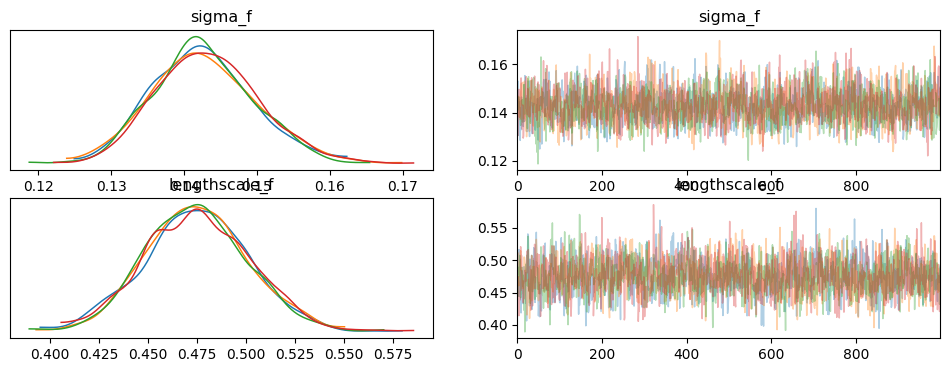

In [28]:
az.plot_trace(az_data, compact=False, var_names=['sigma_f','lengthscale_f']);

In [22]:
fit.log_lik.shape

(4000, 9612)

In [23]:
data_loo = az.loo(az_data)
data_loo

Computed from 4000 posterior samples and 9612 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15125.15    72.02
p_loo      725.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9609  100.0%
 (0.5, 0.7]   (ok)          3    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%